# This notebook constitutes ou project monitor

Imports and settings

In [100]:
%load_ext autoreload
%autoreload 2

import scripts.data_loader as data_loader
import scripts.data_processing as data_processing
import scripts.data_visualization as data_visualization
import scripts.time_series_modelling as time_series_modelling

# Increase the number of columns displayed by pandas
import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importation of data

In [101]:
# Configuration
GOLD_SYMBOL = 'GC=F'
START_DATE = '2019-01-01'
END_DATE = '2024-10-01'

# Load or download data
gold_data_raw = data_loader.get_gold_data(GOLD_SYMBOL, START_DATE, END_DATE, refresh=False)

# Check for missing values
data_processing.missing_values_checking(gold_data_raw)

File found at: c:\Users\polol\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv. 
 Loading data...

Loading data from c:\Users\polol\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv...
Loaded DataFrame columns:
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
No missing values detected.


New features computation

In [102]:

# - **Log Price**: Logarithm of the "Close" price, providing a scaled and stabilized version of the closing price.
# - **Log Return**: Daily difference of Log Price, capturing daily price momentum in a log-scaled format.
# - **Moving Average (20 days)**: Rolling average of the "Close" price over 20 days, highlighting longer-term trends.
# - **Log Mid-Price**: Logarithm of the mid-price (average of "High" and "Low"), stabilizing variance and converting
#   multiplicative changes into additive ones for better analysis.
# - **Log Mid-Price Return**: Daily difference of Log Mid-Price, capturing log-scaled variations in mid-price.
# - **Spread**: Difference between "High" and "Low" prices, indicating price volatility within a time interval.
# - **Imbalance**: Relative volume difference between consecutive intervals, capturing market sentiment and activity.
# - **Volatility_Past_x_days** Volatility for windows (number of daily values used to compute) 8, 15, 21, 50, 90, 120, 260
# - **Volatility_Future_x_days** Volatility for windows (number of daily values used to compute) 8, 15, 21, 50, 90, 120, 260
gold_data_engineered = data_processing.add_metrics(gold_data_raw)

# Remove rows with any missing values, as the new features computed using past data result in the first values of these features being NaN and not computable.
gold_data_engineered_cleaned = data_processing.remove_missing_rows(gold_data_engineered)

Removed 520 rows with missing values. Indices: [Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-05 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-07 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-11 00:00:00'), 

Visualisation of the data

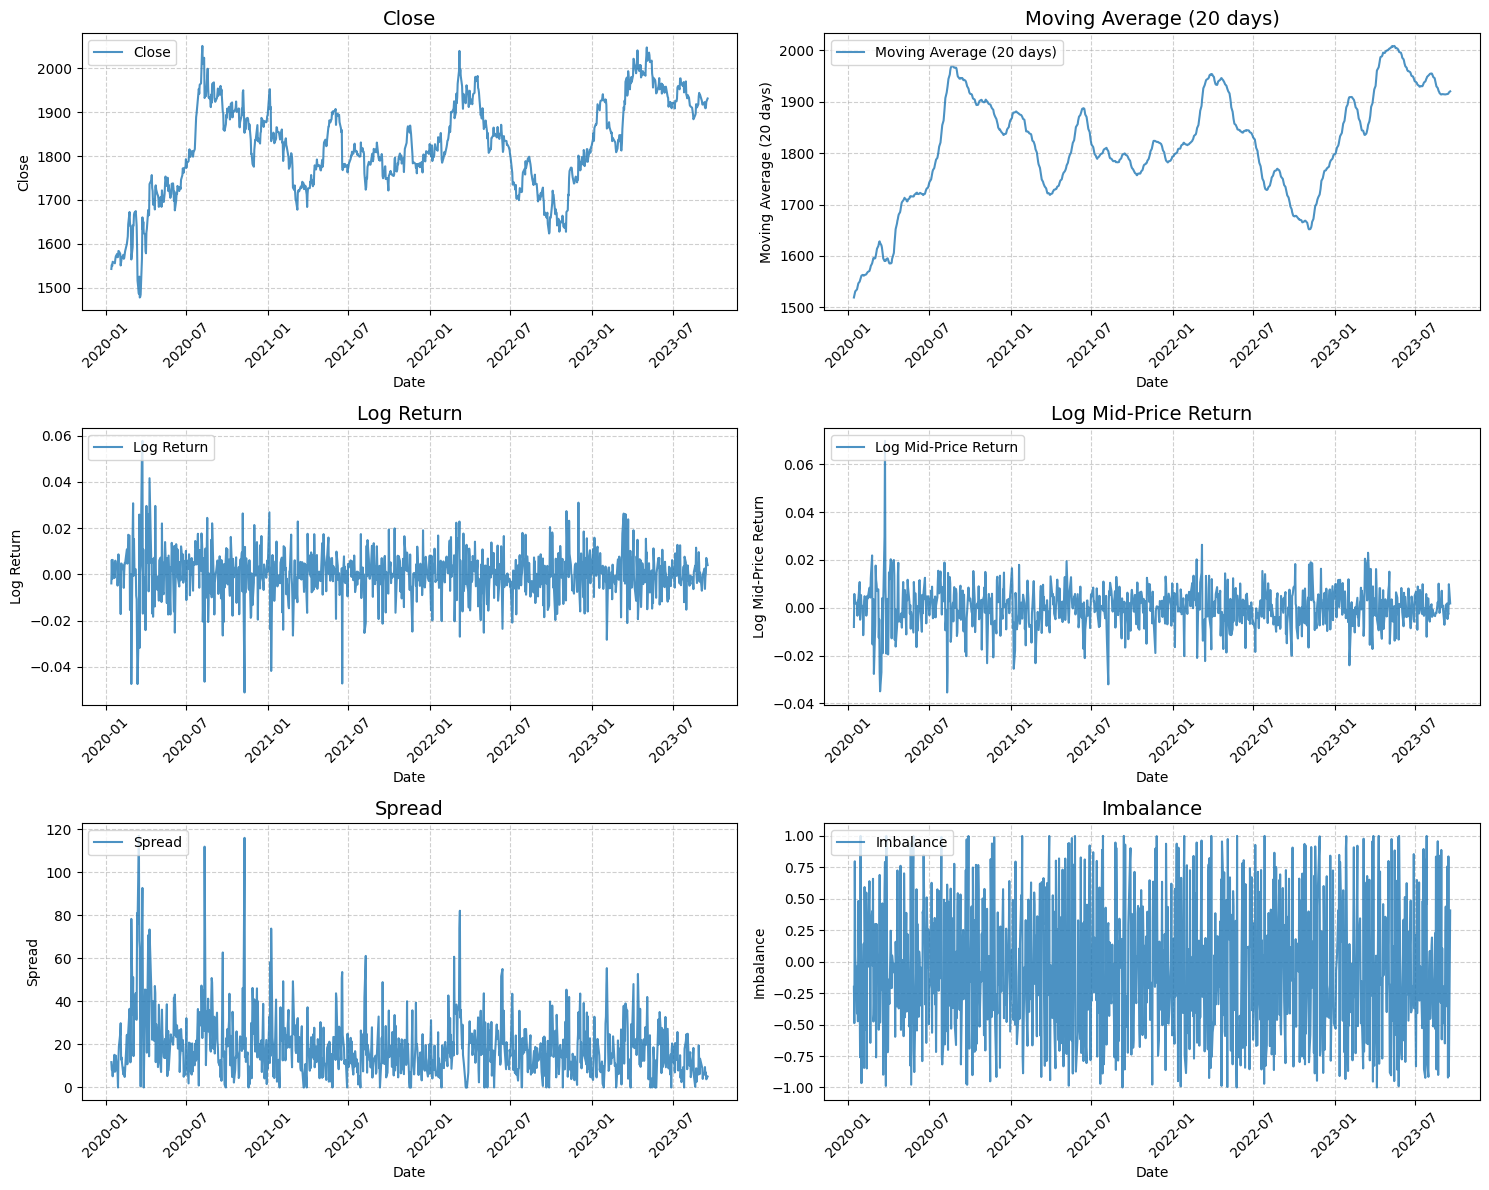

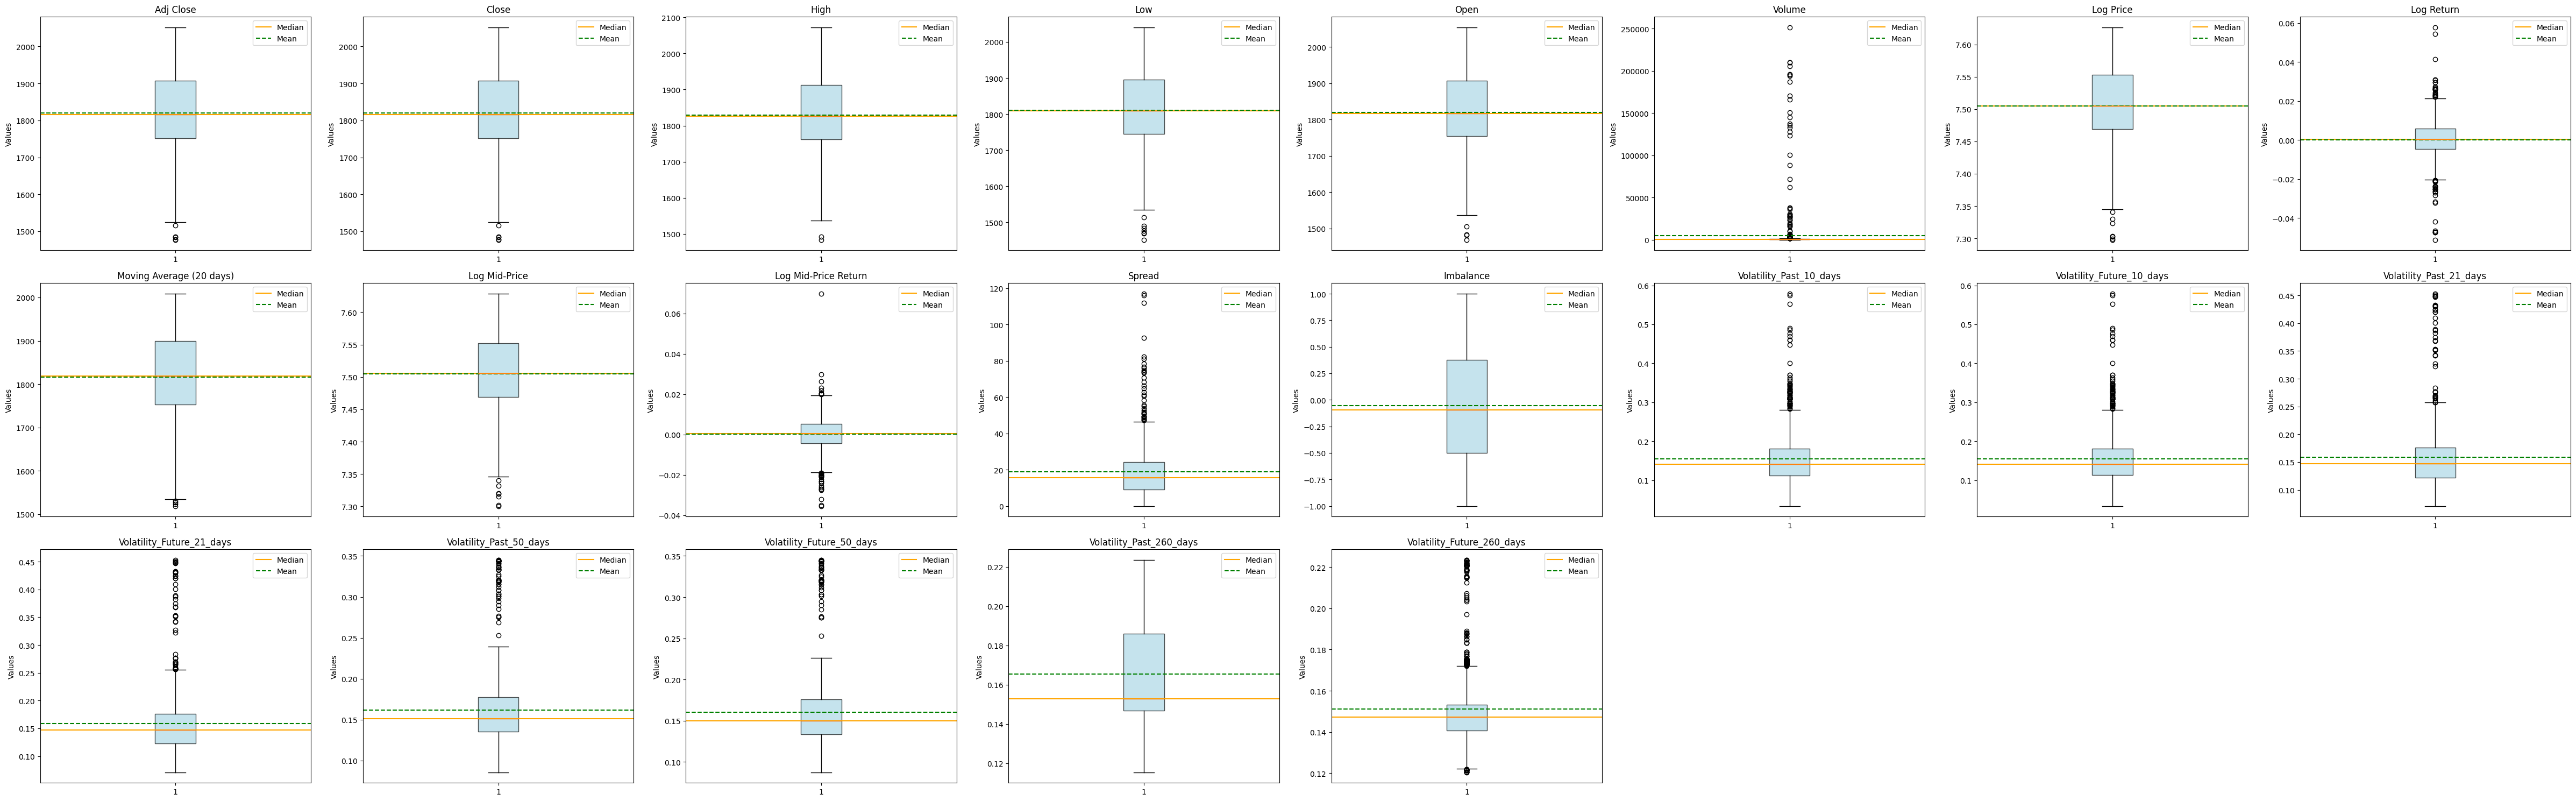

In [103]:
# Visualize all key metrics in a single multi-panel plot
data_visualization.plot_metrics(gold_data_engineered_cleaned[["Close", "Moving Average (20 days)", "Log Return", "Log Mid-Price Return", "Spread", "Imbalance"]])

# Outliers identification
# Plot box plots for all numeric variables
data_visualization.plot_boxplots(gold_data_engineered_cleaned, plots_per_column=8)


We keep only the main features we will use for model training

In [104]:
selected_features = gold_data_engineered_cleaned[['Imbalance', 'Spread', 'Log Mid-Price Return', 'Moving Average (20 days)', 'Log Return', 'Volume', 'Close', 'Volatility_Past_10_days', 'Volatility_Past_21_days', 'Volatility_Past_50_days','Volatility_Past_260_days']]
selected_target_features = gold_data_engineered_cleaned[['Volatility_Future_10_days', 'Volatility_Future_21_days', 'Volatility_Future_50_days','Volatility_Future_260_days']]

display(selected_features)

Imbalance     Spread  Log Mid-Price Return  \
Date                                                     
2020-01-14  -0.200000  11.799927             -0.008016   
2020-01-15  -0.488372   8.300049              0.005792   
2020-01-16   0.798165   7.599976              0.001644   
2020-01-17   0.048544   5.200073              0.002509   
2020-01-21  -0.411765  15.199951              0.001541   
...               ...        ...                   ...   
2023-09-12   0.759036   9.500000             -0.004686   
2023-09-13  -0.921053   5.699951             -0.002247   
2023-09-14   0.836957   7.000000             -0.002750   
2023-09-15  -0.909605   3.800049              0.009865   
2023-09-18   0.407407   5.099976              0.001842   

            Moving Average (20 days)  Log Return  Volume        Close  \
Date                                                                    
2020-01-14               1519.144995   -0.003882      32  1542.400024   
2020-01-15               1522.999994    0.006269      11  1552.099976   
2020-01-16               1526.719995   -0.001999      98  1549.000000   
2020-01-17               1531.029999    0.006307     108  1558.800049   
2020-01-21               1534.940002   -0.001541      45  1556.400024   
...                              ...         ...     ...          ...   
2023-09-12               1914.890002   -0.006259     365  1911.300049   
2023-09-13               1915.220001   -0.001152      15  1909.099976   
2023-09-14               1915.915002    0.000471     169  1910.000000   
2023-09-15               1917.895001    0.007147       8  1923.699951   
2023-09-18               1920.165002    0.004047      19  1931.500000   

            Volatility_Past_10_days  Volatility_Past_21_days  \
Date                                                           
2020-01-14                 0.122961                 0.095134   
2020-01-15                 0.124848                 0.095243   
2020-01-16                 0.126280                 0.095992   
2020-01-17                 0.102140                 0.096449   
2020-01-21                 0.084620                 0.096547   
...                             ...                      ...   
2023-09-12                 0.080586                 0.078028   
2023-09-13                 0.058205                 0.078018   
2023-09-14                 0.051216                 0.076507   
2023-09-15                 0.067127                 0.078980   
2023-09-18                 0.071077                 0.075440   

            Volatility_Past_50_days  Volatility_Past_260_days  
Date                                                           
2020-01-14                 0.104517                  0.115681  
2020-01-15                 0.105152                  0.115562  
2020-01-16                 0.105304                  0.115338  
2020-01-17                 0.096915                  0.115444  
2020-01-21                 0.096310                  0.115413  
...                             ...                       ...  
2023-09-12                 0.088941                  0.141818  
2023-09-13                 0.088966                  0.141599  
2023-09-14                 0.088949                  0.141456  
2023-09-15                 0.089466                  0.141269  
2023-09-18                 0.087552                  0.141130  

[926 rows x 11 columns]

Lead-lag computation

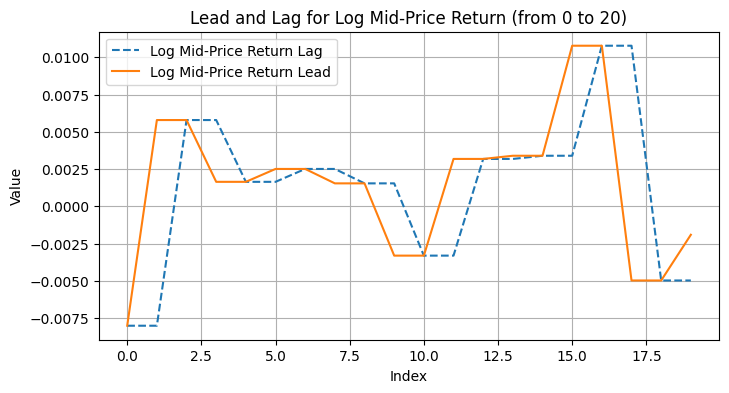

In [105]:
# Step 3: Apply lead-lag transformation
lead_lag_data = data_processing.apply_lead_lag(selected_features, lead_lag_columns=['Log Mid-Price Return'])

# Visualize the transformed features lead-lag
data_visualization.plot_lead_lag(lead_lag_data, ["Log Mid-Price Return"])



Signatures computation

In [106]:
# Compute the signature of order 3 for the lead-lag data
signatures_order_2 = data_processing.compute_signature(
    selected_features,
    order=2,
    windows=[21],
    # exclude_cols = [] # Example: exclude the normalized time if present
)


Quick visualization of the signatures

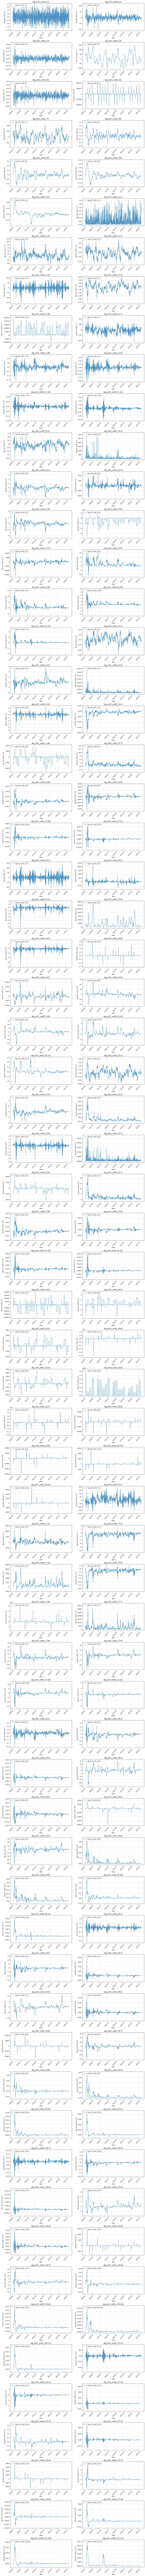

In [107]:
data_visualization.plot_metrics(signatures_order_2)

Data formatting forTime series models

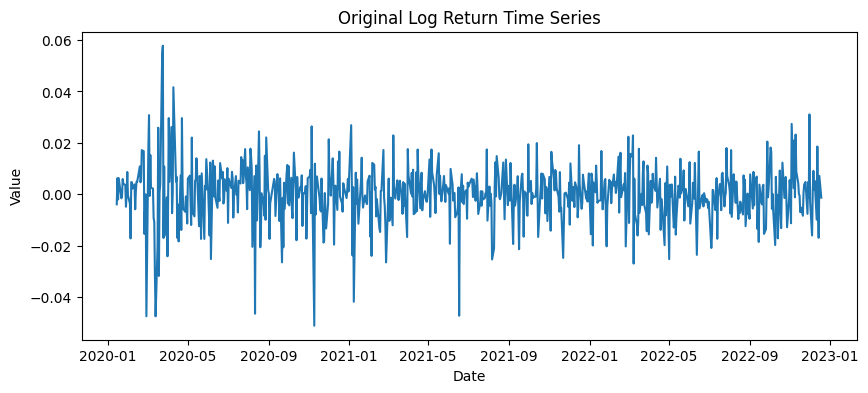

Best GARCH model: GARCH(1, 1) with BIC = -4603.37
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2311.59
Distribution:                  Normal   AIC:                          -4617.19
Method:            Maximum Likelihood   BIC:                          -4603.37
                                        No. Observations:                  740
Date:                Thu, Jan 23 2025   Df Residuals:                      740
Time:                        11:56:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega   

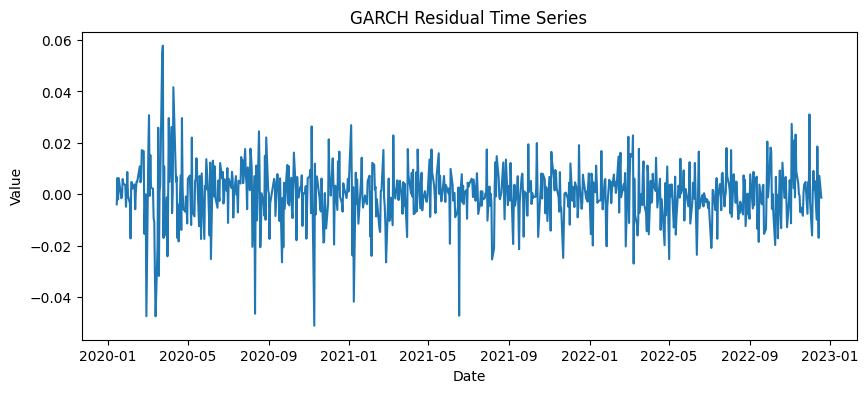

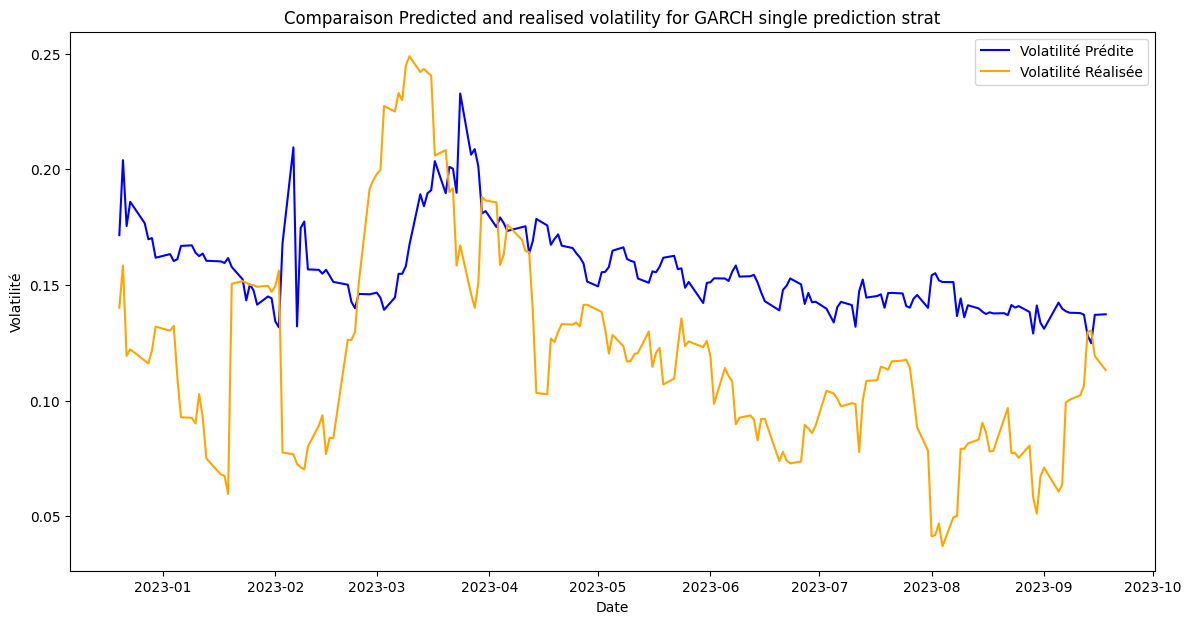

RMSE: 0.054688923966237486


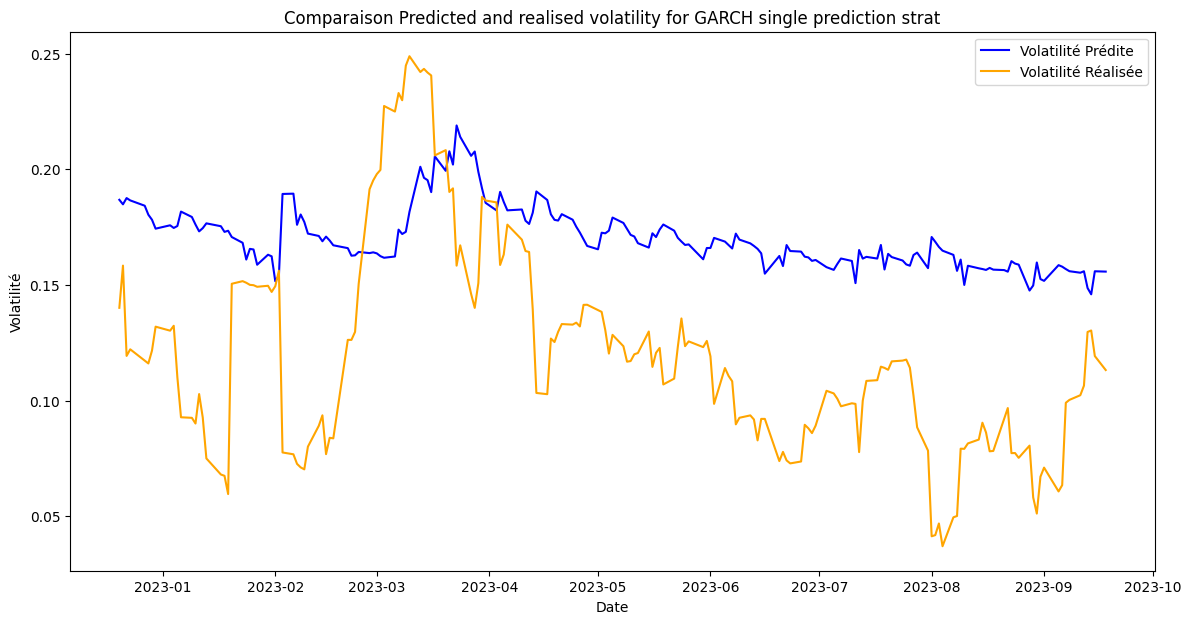

RMSE: 0.06485160331510567


In [108]:
import matplotlib.pyplot as plt

# Split the Close Price time series into train and test set
train_series, test_series, first_test_index, log_r_full_serie = data_processing.split_time_series(selected_features, 'Log Return', 0.2)
#Extract the target volatility
realized_vol = selected_target_features['Volatility_Future_10_days']

# 1) Check stationarity for original time series
time_series_modelling.plot_series(train_series, "Original Log Return Time Series")

# 2) Differencing to make the time series stationary
# stationnary_train_ts = time_series_modelling.differentiate_ts(log_r_full_serie, diff = 1)
#time_series_modelling.plot_series(stationnary_train_ts, "1 Times differentiated time series")


# 3) Fit ARIMA 
#Plot ACP and PACF to make out which ARIMA model chosing
#time_series_modelling.plot_acf_pacf(stationnary_train_ts)
#ARIMA_model = time_series_modelling.fit_arima(train_series, 2, 1, 2)
#print(ARIMA_model.summary())
# Extract residuals from the ARIMA model
#ARIMA_residuals = ARIMA_model.resid[2:]    # We remove the two frist values which are aberrant
#time_series_modelling.plot_series(ARIMA_residuals, "ARIMA Residual Time Series")



# 4) Fit GARCH on the residuals
GARCH_model, best_p, best_q = time_series_modelling.fit_garch_auto(train_series, p_max=10, q_max=10,criterion='bic')
print(GARCH_model.summary())

# Extract residuals from the GARCH model
GARCH_residuals = GARCH_model.resid
time_series_modelling.plot_series(GARCH_residuals, "GARCH Residual Time Series")




df_predicted_vol_multi, df_realized_vol_multi = time_series_modelling.forecast_volatility_garch(
    5,
    5,
    log_r_full_serie,
    first_test_index,
    realized_vol,
    10,
    strategy = "multi"
)

df_predicted_vol_single, df_realized_vol_single = time_series_modelling.forecast_volatility_garch(
    5,
    5,
    log_r_full_serie,
    first_test_index,
    realized_vol,
    10,
    strategy = "single"
)


# Exemple d'utilisation :
# Supposons que vous avez déjà obtenu df_predicted_vol et df_realized_vol
# predicted_vol_df, realized_vol_df = forecast_volatility_garch(...)

# Appeler la fonction de traçage
time_series_modelling.plot_predicted_vs_realized_volatility(df_predicted_vol_single, df_realized_vol_single, title = 'Comparaison Predicted and realised volatility for GARCH single prediction strat')

time_series_modelling.plot_predicted_vs_realized_volatility(df_predicted_vol_multi, df_realized_vol_multi, title = 'Comparaison Predicted and realised volatility for GARCH single prediction strat')




Data formatting for Supervised Learning

In [135]:

# Step 4: Normalize the time column which can't be normalise as needed by transformers:
# time_normalized_data = data_processing.normalize_features(gold_data)

# We split the dataframe into a train and a test set:
X_train, X_test, Y_train, Y_test = data_processing.split_train_test(selected_features, signatures_order_2, selected_target_features, 'Volatility_Future_10_days',  0.2, random_state = 42)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters: {'feature_selector__k': 3, 'regressor': LinearRegression()}
            Realized Volatility  Predicted Volatility
Date                                                 
2022-12-27             0.117343              0.150840
2022-12-28             0.116100              0.151193
2022-12-29             0.121640              0.151117
2022-12-30             0.132002              0.151700
2023-01-03             0.130269              0.152350
RMSE: 0.05607796048614844
MAE: 0.04921066091919652
R² Score: -0.5321511899097806


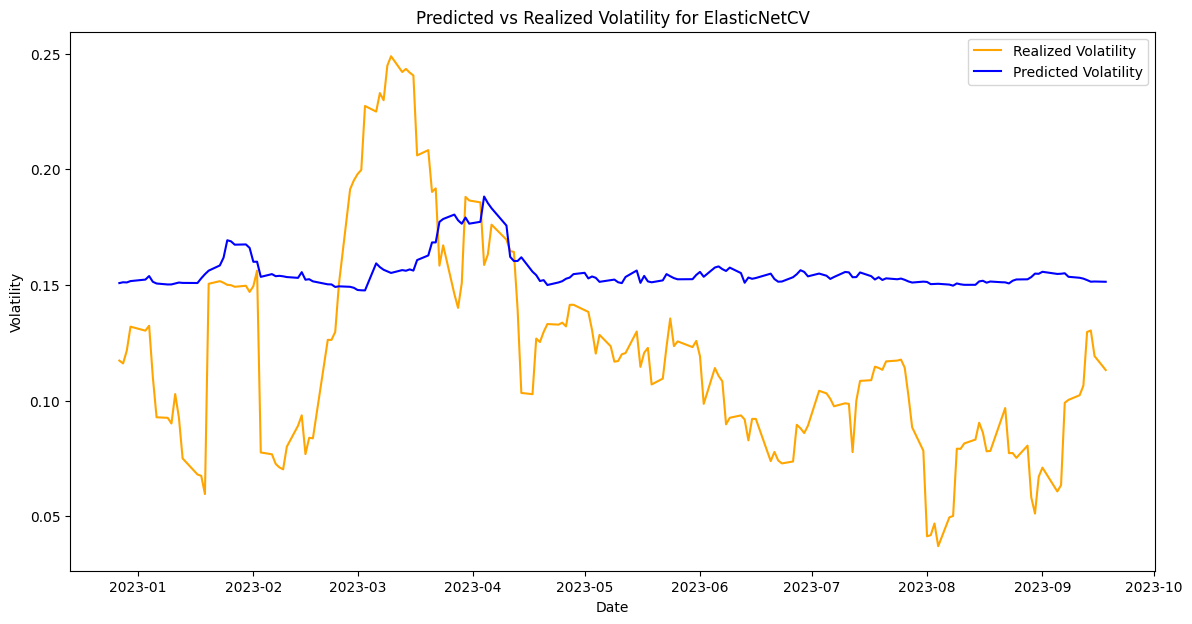

In [136]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define feature selector
feature_selector = SelectKBest(score_func=f_regression, k=10)  # Adjust 'k' as needed

# Initialize scaler
scaler = StandardScaler()

# Define models (only one should be active at a time)
# Uncomment the desired model and comment out the others

# Model 1: Lasso Regression
#model = Lasso(random_state=42, max_iter=10000)

# Model 2: Ridge Regression
# model = Ridge(random_state=42, max_iter=10000)

# Model 3: ElasticNet Regression
# model = ElasticNet(random_state=42, max_iter=10000)

# Model 4: Ordinary Least Squares (Linear Regression)
model = LinearRegression()

# Create pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('feature_selector', feature_selector),
    ('regressor', model)
])

# Define parameter grid for GridSearchCV
param_grid = {
    # Parameters for Lasso
    #'regressor': [Lasso(random_state=42, max_iter=10000)],
    #'regressor__alpha': [0.01, 0.1, 1.0, 10.0],
    
    # Uncomment below for Ridge
    # 'regressor': [Ridge(random_state=42, max_iter=10000)],
    # 'regressor__alpha': [0.01, 0.1, 1.0, 10.0],
    
    # Uncomment below for ElasticNet
    # 'regressor': [ElasticNet(random_state=42, max_iter=10000)],
    # 'regressor__alpha': [0.01, 0.1, 1.0, 10.0],
    # 'regressor__l1_ratio': [0.1, 0.5, 0.9],
    
    # Uncomment below for Linear Regression (no hyperparameters)
    'regressor': [LinearRegression()],
    
    # Parameters for feature selector
    'feature_selector__k': [3,5,8,10,15, 20, 30]
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, Y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on test set
Y_pred = best_model.predict(X_test)

# Convert predictions to pandas Series with the same index as X_test
Y_pred_series = pd.Series(Y_pred, index=X_test.index, name='Predicted Volatility')

# Ensure Y_test is a pandas Series
if isinstance(Y_test, pd.DataFrame):
    Y_test_series = Y_test.iloc[:, 0]
else:
    Y_test_series = Y_test.copy()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Realized Volatility': Y_test_series,
    'Predicted Volatility': Y_pred_series
})

print(comparison_df.head())

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# Plotting Function
def plot_predicted_vs_realized(df, title='Predicted vs Realized Volatility'):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Realized Volatility'], label='Realized Volatility', color='orange')
    plt.plot(df.index, df['Predicted Volatility'], label='Predicted Volatility', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Plot the results
plot_predicted_vs_realized(comparison_df, title='Predicted vs Realized Volatility for ElasticNetCV')


In [127]:
print(X_train.columns)

Index(['Imbalance', 'Spread', 'Log Mid-Price Return',
       'Moving Average (20 days)', 'Log Return', 'Volume', 'Close',
       'Volatility_Past_10_days', 'Volatility_Past_21_days',
       'Volatility_Past_50_days',
       ...
       'sig_w21_ord2_(11,2)', 'sig_w21_ord2_(11,3)', 'sig_w21_ord2_(11,4)',
       'sig_w21_ord2_(11,5)', 'sig_w21_ord2_(11,6)', 'sig_w21_ord2_(11,7)',
       'sig_w21_ord2_(11,8)', 'sig_w21_ord2_(11,9)', 'sig_w21_ord2_(11,10)',
       'sig_w21_ord2_(11,11)'],
      dtype='object', length=143)
